# Day 1, Practical 2
## Handling simulation trajectory data

MDAnalysis is able to read a wide variety of different simulation coordinate formats. A full list of these can be seen in the [coordinates documentation](https://docs.mdanalysis.org/stable/documentation_pages/coordinates/init.html#supported-coordinate-formats). Of these, many are trajectory formats which hold temporal information from simulations such as coordinates, dimensions, velocities, and forces.

Here we demonstrate how one can use MDAnalysis to read, explore, and write trajectory data.

### Package imports

In [4]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
%matplotlib inline

## 1. Reading a trajectory

Loading a trajectory is done in the same way as loading any type of coordinates (as shown in session 1). All you have to do is create a `Universe` object by passing it a topology and the trajectory (here in this case a PSF file and DCD trajectory respectively).

In [44]:
# First let's load a PSF and DCD from the MDAnalysis test data
from MDAnalysis.tests.datafiles import PSF, DCD

# Now let's load the XTC trajectory
u = mda.Universe(PSF, DCD)

Trajectory functionality is centered around the `Universe.trajectory` object.

In [45]:
u.trajectory

<DCDReader /home/bioc1523/software/anaconda/install/envs/all/lib/python3.7/site-packages/MDAnalysisTests/data/adk_dims.dcd with 98 frames of 3341 atoms>

This `trajectory` object has a length in `frames` and a time unit of **picoseconds** (see here for more information about the [MDAnalysis base units](https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/units.html#id4).

The `trajectory` object has many useful attributes, such as the the number of frames `n_frames`, the time between frames `dt`, the total trajectory time `totaltime`.

In [46]:
# print the number of frames
u.trajectory.n_frames

98

In [47]:
# You can also get the number of frames by calling `len` on the trajectory object
len(u.trajectory)

98

In [48]:
# We can get the time between frames with `dt`
u.trajectory.dt

0.9999999119200186

In [49]:
# And the total simulation time from `totaltime`
u.trajectory.totaltime

96.9999914562418

In [50]:
# The trajectory object has a ton of other attributes not shown here
# for example you can get the file format through `format`
u.trajectory.format

'DCD'

### Exercise 1

From MDAnalysis.tests.datafiles get the GRO topology and XTC trajectory. Work out the total number of frames, and the total simulation length of the trajectory.

In [51]:
# Exercise 1 solution
from MDAnalysis.tests.datafiles import GRO, XTC
u_new = mda.Universe(GRO, XTC)
print('number of frames: ', u_new.trajectory.n_frames)
print('total time: ', u_new.trajectory.totaltime)

number of frames:  10
total time:  900.0000686645508


In [ ]:
# Exercise 1

It's also possible to load / concatenate multiple trajectories together in one go using MDAnalysis' [ChainReader](https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/coordinates/chain.html?highlight=chainreader#chainreader-mdanalysis-coordinates-chain).

This can be done simply by passing several trajectories to the Universe when creating the object.

In [53]:
# Let's assume we wanted to load several DCD files
u_multi = mda.Universe(PSF, DCD, DCD)

# Now we have 2 times the number of frames [ 98 frames per DCD trajectory ]
print(u_multi.trajectory.n_frames)

196


In [54]:
# We can also just load a list of trajectories
traj_list = [DCD, DCD, DCD]

u_multi = mda.Universe(PSF, traj_list)

# Now we have concatenated the trajectory 3 times
print(u_multi.trajectory.n_frames)

294


## 2. The Timestep object

One of the key components of trajectories is the *Timestep* object `ts`. This is the object that holds the trajectory information **specific to the current frame**.

This information mainly includes:
* The frame number and time
* Unitcell dimensions as `[A, B, C, alpha, beta, gamma]` (or `None` if not available)
* The positions (also forces and/or velocities if available)


In [66]:
# Here we load the an AMBER topology and trajectory with coordinate, velocity and forces information
from MDAnalysis.tests.datafiles import PRM_NCBOX, TRJ_NCBOX
u = mda.Universe(PRM_NCBOX, TRJ_NCBOX)

In [83]:
# Timestep is available via `ts`
u.trajectory.ts

< Timestep 0 with unit cell dimensions [28.818764 28.278753 27.726164 90.       90.       90.      ] >

In [84]:
# Getting the current frame from `ts`
u.trajectory.ts.frame

0

In [85]:
# Getting the current time from `ts`
u.trajectory.ts.time

1.0

In [86]:
# Getting the dimensions from `ts`
u.trajectory.ts.dimensions

array([28.818764, 28.278753, 27.726164, 90.      , 90.      , 90.      ],
      dtype=float32)

In [87]:
# `ts` also holds positions
u.trajectory.ts.positions

array([[15.249873 , 12.578178 , 15.191731 ],
       [14.925511 , 13.58888  , 14.944009 ],
       [15.285703 , 14.3409605, 15.645962 ],
       ...,
       [ 3.9575078, 14.525827 , 16.14651  ],
       [ 4.6214457, 14.670319 , 15.472312 ],
       [ 4.3571763, 14.856422 , 16.950998 ]], dtype=float32)

In [88]:
# `ts` has a convenient `has_forces` attribute to let you know that forces are available
print(u.trajectory.ts.has_forces)
print(u.trajectory.ts.forces)

True
[[  35.912895     7.5411134  -62.774    ]
 [ -90.35279    163.55951     27.480358 ]
 [  18.25486    -50.773525    18.73405  ]
 ...
 [-211.5503    -127.57705     14.248226 ]
 [  65.75678     44.437996   -59.866737 ]
 [  65.71979     47.376717    45.049736 ]]


### Exercise 2

Check if the Timestep has velocities and print them out

In [94]:
# Exercise 2 - solution
if u.trajectory.ts.has_velocities:
    print(u.trajectory.ts.velocities)

[[-10.8446045   -3.3365366   -6.420965  ]
 [  0.03857359   0.51404047  -5.497332  ]
 [ 17.19698      1.9232591  -15.253312  ]
 ...
 [  3.362785     3.7809153    3.04019   ]
 [  8.890362   -26.293007     0.64297414]
 [  4.1646843   23.021692    -4.7289677 ]]


In [ ]:
# Exercise 2

Whilst the *Timestep* information is available, one would normally not access the information it contains by calling `Universe.trajectory.ts` directly.

Instead, as shown in session 1, the information contained in the *Timestep* is passed along to other parts of the `Universe`.

For example, as shown in session 1, coordinate/velocity/forces data is directly accessible via AtomGroups instead.

In [101]:
# create an atomgroup from all the atoms
ag = u.atoms
print("AtomGroup positions:\n", ag.positions)
print("ts positions:\n", u.trajectory.ts.positions)

AtomGroup positions:
 [[15.249873  12.578178  15.191731 ]
 [14.925511  13.58888   14.944009 ]
 [15.285703  14.3409605 15.645962 ]
 ...
 [ 3.9575078 14.525827  16.14651  ]
 [ 4.6214457 14.670319  15.472312 ]
 [ 4.3571763 14.856422  16.950998 ]]
ts positions:
 [[15.249873  12.578178  15.191731 ]
 [14.925511  13.58888   14.944009 ]
 [15.285703  14.3409605 15.645962 ]
 ...
 [ 3.9575078 14.525827  16.14651  ]
 [ 4.6214457 14.670319  15.472312 ]
 [ 4.3571763 14.856422  16.950998 ]]


Similarly, the `dimensions` can be accessed directly from `Universe`.

In [102]:
print("Universe dimensions: ", u.dimensions)
print("ts dimensions: ", u.trajectory.ts.dimensions)

Universe dimensions:  [28.818764 28.278753 27.726164 90.       90.       90.      ]
ts dimensions:  [28.818764 28.278753 27.726164 90.       90.       90.      ]


## 3. Traversing through a trajectory

Up until this point, we have primarily been inspecting only a single frame of the `trajectory` object. By default when creating a `Universe`, the *Timestep* is loaded with the information from the first (zero-th) frame in the trajectory.

Here we look at how we can traverse through the trajectory and access the data from different frames.

We can consider the `trajectory` object to be an iterator that loads trajectory data from a source (i.e. in most cases the input trajectory file), and feeds the relevant data to the *Timestep* object.

The following operations can be done to access the trajectory:
* Random access via trajectory indexing
* Iterating over all frames
* Slicing to iterate over a sub-section of the trajectory

**Note:** As is standard in python, `trajectory` access is done via **0-based indices**. So the first frame is `0`, and the final frame is `n_frames - 1`.

### 3.1 Trajectory indexing

It is possible to randomly access any frame along a trajectory by passing the index of the frame to the trajectory.

In [131]:
# First let's create a new universe using PRM_NCBOX and TRJ_NCBOX
u = mda.Universe(PRM_NCBOX, TRJ_NCBOX)

# as we can see on creation we access the first frame in the trajectory
print('current frame: ', u.trajectory.frame)
print('total number of frames: ', u.trajectory.n_frames)

current frame:  0
total number of frames:  10


In [132]:
# Let's create an atomgroup for the first two atoms in the Universe
# and check their current position at frame 0
first_two_atoms = u.atoms[:2]
print(first_two_atoms.positions)

[[15.249873 12.578178 15.191731]
 [14.925511 13.58888  14.944009]]


In [133]:
# Now let's move to the 7th frame
u.trajectory[6]

< Timestep 6 with unit cell dimensions [27.78876 27.26805 26.73521 90.      90.      90.     ] >

In [134]:
# As we can see the frame number as now updated accordingly
print('current frame: ', u.trajectory.frame)

current frame:  6


In [135]:
# The AtomGroup also automatically updates with the new Timestep data
print(first_two_atoms.positions)

[[15.79226   12.6949625 15.421089 ]
 [15.945778  13.682353  14.985668 ]]


**Note:** It is particularly important to remember that AtomGroups are not static objects. Whilst the atoms they represent do not change (see UpdatingAtomGroup for when this is not the case), the positions (and forces or velocities if available) will change as you traverse through the trajectory.


It is also worth noting that unless the trajectory is held in memory (see **Section 4**) any changes to variables that change with `Timestep` are temporary.

For example, if you were to override the position of an AtomGroup for a given frame, then seek to another frame and come back to the original frame, the positions would be updated back to reflect the contents of the trajectory file:

In [136]:
# Let's start from frame 0 and override the positions of `first_two_atoms`
u.trajectory[0]

# `first_two_atoms` positions beforehand
print('frame 0 positions: ', first_two_atoms.positions)

# `first_two_atoms` after being zeroed
first_two_atoms.positions = 0
print('zeroed positions: ', first_two_atoms.positions)

frame 0 positions:  [[15.249873 12.578178 15.191731]
 [14.925511 13.58888  14.944009]]
zeroed positions:  [[0. 0. 0.]
 [0. 0. 0.]]


In [140]:
# Now let's go the before last frame
u.trajectory[-2]
first_two_atoms.positions

array([[14.799454, 15.214347, 14.714555],
       [15.001984, 15.870884, 13.868363]], dtype=float32)

In [141]:
# And now we come back to frame 0
u.trajectory[0]

# positions are no longer zeroed
first_two_atoms.positions

array([[15.249873, 12.578178, 15.191731],
       [14.925511, 13.58888 , 14.944009]], dtype=float32)

### 3.2 Iterating through the trajectory

Iterating through a trajectory is the most common way to traverse a trajectory.

For example one could access every frame in the trajectory and store the current time using the following:

In [119]:
# Create a list for the times
times = []

for ts in u.trajectory:
    times.append(u.trajectory.time)
    
print(times)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


### 3.3 Trajectory slicing

Rather than iterating through the entire trajectory, it is possible to slice the trajectory using a `[start:stop:step]` pattern.

In [120]:
# Let's slice starting at the second frame, ending on the before last frame
# and skipping every other frame

times = []

for ts in u.trajectory[1:-2:2]:
    times.append(u.trajectory.time)
    
print(times)

[2.0, 4.0, 6.0, 8.0]


It is also possible to use fancy indexing to access frames in a given order

In [121]:
# indices of frames to access
indices = [9, 5, 4, 8, 1]

times = []

for ts in u.trajectory[indices]:
    times.append(u.trajectory.time)
    
print(times)

[10.0, 6.0, 5.0, 9.0, 2.0]


### Exercise 3

Create a reversed list of the trajectory times

In [122]:
# Exercise 3 -- solution
times = []

for ts in u.trajectory[::-1]:
    times.append(u.trajectory.time)
    
print(times)

[10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]


In [ ]:
# Exercise 3

## 4. Transfering to memory

By default MDAnalysis uses an iterative I/O model. That is to say that it loads trajectory data from disk as necessary. This is done so that very large trajectories can still be read by MDAnalysis without filling up the machine's RAM.

In some cases it can be useful to instead hold the trajectory data in memory:
1. It is much faster to iterate through an in-memory trajectory
2. Changes to the trajectory data is not overwritten


You can create an in-memory trajectory directly on `Universe` creation by setting the `in_memory` keyword.

In [149]:
u = mda.Universe(PRM_NCBOX, TRJ_NCBOX, in_memory=True)

In [150]:
# Note how the trajectory is now stored in 'MEMORY' format
# instead of the input ['NCDF', 'NC'] input format
u.trajectory.format

'MEMORY'

It's also possible to transfer the trajectory to memory after creating the `Universe` using `transfer_to_memory`.

In [151]:
# It's also possible to transfer
u = mda.Universe(PRM_NCBOX, TRJ_NCBOX)
print('starting format: ', u.trajectory.format)

u.transfer_to_memory()
print('new format: ', u.trajectory.format)

starting format:  ['NCDF', 'NC']
new format:  MEMORY


When in-memory, changes to trajectory data like `positions` do not get overwritten if you change frames.

In [152]:
print('current frame: ', u.trajectory.frame)
print('current positions: ', u.atoms.positions)

# zero the positions
u.atoms.positions = 0
print('zeroed positions: ', u.atoms.positions)

current frame:  0
current positions:  [[15.249873  12.578178  15.191731 ]
 [14.925511  13.58888   14.944009 ]
 [15.285703  14.3409605 15.645962 ]
 ...
 [ 3.9575078 14.525827  16.14651  ]
 [ 4.6214457 14.670319  15.472312 ]
 [ 4.3571763 14.856422  16.950998 ]]
zeroed positions:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [154]:
# Seek to a new frame
u.trajectory[-1]
print('frame -1 positions: ', u.atoms.positions)

# See back to frame 0
u.trajectory[0]

# positions remain zero for frame 0
print('frame 0 positions: ', u.atoms.positions)

frame -1 positions:  [[14.392319  16.360231  14.511796 ]
 [13.606518  17.076824  14.27282  ]
 [14.025402  18.076998  14.383686 ]
 ...
 [ 5.8899493 16.821993   7.454993 ]
 [ 6.58759   17.260208   6.967657 ]
 [ 5.7498684 15.999697   6.9854836]]
frame 0 positions:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### Exercise 4

Evaluate how much faster you can retrieve trajectory times from an in-memory trajectory compared to reading from file.

*Hint:* use %timeit

In [155]:
# Exercise 4 -- solution
u_memory = mda.Universe(PRM_NCBOX, TRJ_NCBOX, in_memory=True)
u_disk = mda.Universe(PRM_NCBOX, TRJ_NCBOX)

In [156]:
%timeit [ts.time for ts in u_memory.trajectory]

145 µs ± 3.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [157]:
%timeit [ts.time for ts in u_disk.trajectory]

1.02 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# Exercise 4

## 5. Visualizing a trajectory

As we did in the previous session, it is possible to use NGLView to traverse through the trajectory visually.

In [158]:
from MDAnalysis.tests.datafiles import PSF, DCD
adk = mda.Universe(PSF, DCD)
nv.show_mdanalysis(adk)

NGLWidget(max_frame=97)

## 6. Updating AtomGroups

In **section 3** we discuss how AtomGroups have a static set of atoms but have positions (forces, velocities, etc..) that update as you traverse through a trajectory.

There is a special type of the `AtomGroup` class which allows for a dynamic selection of atoms that changes as you traverse through the trajectory. This class it called the `UpdatingAtomGroup`. To use it, you must pass the `updating` flag to `select_atoms`.

To illustrate this, we look at an ACE residue in a box of water. We create a selection based on the number of waters within 5 Angstroms of the ACE residue. As we traverse through the trajectory, the `UpdatingAtomGroup` will change in the number of atoms it contains, whilst the `AtomGroup` will not.

In [169]:
# ACE residue in a box of water
u = mda.Universe(PRM_NCBOX, TRJ_NCBOX)

# Create a normal atom group
ag = u.select_atoms('resname WAT and around 5 resname ACE')
updating_ag = u.select_atoms('resname WAT and around 5 resname ACE', updating=True)

In [171]:
ag_atoms = []
updating_ag_atoms = []

for ts in u.trajectory:
    ag_atoms.append(len(ag.atoms))
    updating_ag_atoms.append(len(updating_ag.atoms))

# These number of atoms remains the same
print(ag_atoms)

# The number of atoms changes
print(updating_ag_atoms)

[87, 87, 87, 87, 87, 87, 87, 87, 87, 87]
[87, 81, 78, 84, 76, 79, 83, 90, 83, 72]


**Note:** Whilst `UpdatingAtomGroup` are sometimes very useful, they are also much more computational expensive to use as the selection (in this case a distance search around the ACE residue) has to be done at every step along the trajectory. We recommend using these sparsely.

## 7. Writing trajectory files

Aside from reading trajectories, MDAnalysis is also able to write them out. A list of formats which can be written to is shown in the [supported formats documentation](https://docs.mdanalysis.org/dev/documentation_pages/coordinates/init.html#id23).

The most common way to write out files is by using the `Writer` class as a context manager.

Below we show an example of reading in an AMBER netcdf trajectory (ACE residue in a box of water used in previous sections), and writing it out to a DCD trajectory.

The basic `Writer` usage pattern is:
1. Create a context manager for the Writer using `with`
  * Needs passing the number of atoms that will be written to file
  * Can optionally pass `format` to specific which file format will be used, otherwise the output file extension will be used
2. Iterate through the trajectory frames you wish to write
3. Pass the `AtomGroup` to write out at each frame to the `write()` method
4. Close the output trajectory file (done automatically via the context manager)

There are other ways to write out coordinates, these can be seen in the [user guide entry on trajectory writing](https://userguide.mdanalysis.org/stable/reading_and_writing.html#frames-and-trajectories).

In [172]:
u = mda.Universe(PRM_NCBOX, TRJ_NCBOX)

# Writer requires passing the number of atoms `n_atoms`
# as a keyword argument, this is usually the number of 
# atoms in the atomgroup to write here it will be all
# the atoms in the universe.
ag = u.atoms

# The format argument is not necessary, as it is taken from
# the extension of the output file, but can sometimes be useful
with mda.Writer('test.dcd', n_atoms=ag.n_atoms, format='DCD') as W:
    # Iterate through the trajectory and write at every step
    for ts in u.trajectory:
        W.write(ag)

## 8. Case study 1: RVX-OH binding to BRD4(1)

Here we have a 20 ns simulation of the binding of the RVX-OH ligand to the first bromodomain of human BRD4. The simulation is based on the crystal structure [4MR3](https://www.rcsb.org/structure/4mr3).

In [14]:
# Note; due to trajectory conversion dt was lost, we set it manually to 50 ps
rvx_oh = mda.Universe('data/rvx-oh.pdb', 'data/rvx-oh.dcd', dt=50)
nv.show_mdanalysis(rvx_oh)

NGLWidget(max_frame=400)

### Exercise 5

When looking at protein-ligand complexes, a common analysis is to look at how far the ligand moves out of the binding site. One way to do this is to purely look at the center of mass distances between the ligand and the binding site residues.

Using this trajectory, calculate and plot the center of mass distances between the ligand (`'resname LIG'`) and the binding site defined as the residues within 5 Angstrom of the ligand (`'byres protein and around 5 resname LIG'`).

**Notes:** MDAnalysis AtomGroups have a convenient `center_of_mass()` method to get their center of mass at the current frame. Additionally, `MDAnalysis.lib.distances` has a `calc_bonds` method which allows users to calculate periodic aware distances between two sets of positions.

Text(0.5, 0, 'Simulation time (ns)')

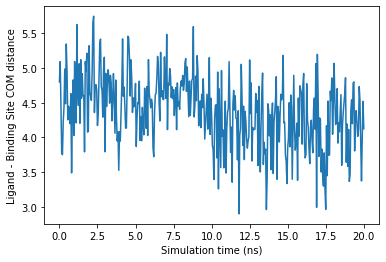

In [16]:
# Exercise 5 -- solution
from MDAnalysis.lib.distances import calc_bonds

ligand = rvx_oh.select_atoms('resname LIG')
# Extra question - using an UpdatingAtomGroup is slow, how could you speed this up?
# Hint: MDAnalysis.lib.distances has a capped_distance method which could be useful
binding_site = rvx_oh.select_atoms('byres protein and around 5 resname LIG', updating=True)

com_distances = np.empty(rvx_oh.trajectory.n_frames)
times = com_distances.copy()

for i, ts in enumerate(rvx_oh.trajectory):
    com_distances[i] = calc_bonds(coords1=ligand.center_of_mass(),
                                  coords2=binding_site.center_of_mass(),
                                  box=rvx_oh.dimensions)
    times[i] = ts.time / 1000 # get time in ns

plt.plot(times, com_distances)
plt.ylabel('Ligand - Binding Site COM distance')
plt.xlabel('Simulation time (ns)')

In [13]:
# Exercise 5

1.0000000328495406

What other metrics could you use to analyze binding here? If you have time, have a play with the data to see what other insights you could get from it.

In [ ]:
# Optional - what other metrics could you extract?

## 9. Case study 2: Conformational transisitions of ADK

The enzyme *adenylate kinase* catalyzes the reaction ATP + AMP <-> 2 ADP. It undergoes a *conformational transition* beteween a closed ([1AKE](https://www.rcsb.org/structure/1AKE)) and open ([4AKE](https://www.rcsb.org/structure/4AKE)) conformational state [1], even in the absence of substrates.

![AdK conformations (from [2])](figs/angle_defs.png)

1. S. L. Seyler and O. Beckstein. Sampling of large conformational transitions: Adenylate kinase as a testing ground. Molec. Simul., 40(10–11):855–877, 2014. doi: 10.1080/08927022.2014.919497
2. O. Beckstein, E. J. Denning, J. R. Perilla, and T. B. Woolf. Zipping and unzipping of adenylate kinase: Atomistic insights into the ensemble of open ↔ closed transitions. 394(1):160–176, 2009. doi: 10.1016/j.jmb.2009.09.009
3. Perilla JR, Beckstein O, Denning EJ, Woolf TB. Computing ensembles of transitions from stable states: Dynamic importance sampling. J Comput Chem. 2011 30 Jan;32(2):196–209. doi: 10.1002/jcc.21564

Here we begin by looking at an ensemble of 200 trajectories of varying length generated via dynamic importance sampling [3].

In [32]:
# Get the data
from MDAnalysisData.datasets import fetch_adk_transitions_DIMS

adk = fetch_adk_transitions_DIMS()

DIMS.tar.gz: 731MB [01:00, 12.2MB/s]                               


In [47]:
# Let's look at more information about this data
adk.DESCR??

Analyzing the full ensemble can be time consuming, so we will only look at the first 50 trajectories.

In [41]:
# Let's create an universe and visualise the protein
adk_u = mda.Universe(adk.topology, adk.trajectories[:50])
nv.show_mdanalysis(adk_u)

NGLWidget(max_frame=4943)

### Exercise 6

As we can see from the above trajectory, ADK rapidly goes from a closed to an open conformation.

Using the below given definition of the LID and NMR theta angles (`theta_LID()` and `theta_NMP()` respectively), plot:
1. The timeseries of the angles
2. The angles against each other

In [42]:
from numpy.linalg import norm

def theta_NMP(ag):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees
    
    Parameters
    ----------
    ag : MDAnalysis.Universe or MDAnalysis.AtomGroup
    """
    C = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 90:100 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 35:55 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(ag):
    """Calculate the LID-CORE angle for E. coli AdK in degrees
    
    Parameters
    ----------
    ag : MDAnalysis.Universe or MDAnalysis.AtomGroup
    """
    C = ag.select_atoms("resid 179:185 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 125:153 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

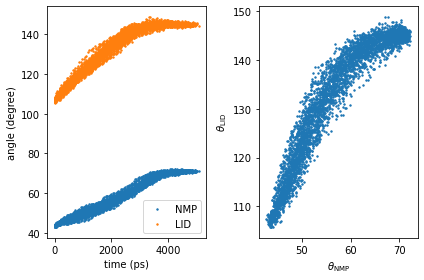

In [58]:
# Exercise 6 -- solution
times = np.empty(adk_u.trajectory.n_frames)
LID = np.empty(adk_u.trajectory.n_frames)
NMP = np.empty(adk_u.trajectory.n_frames)

# iterate through the trajectory and gather data
for i, ts in enumerate(adk_u.trajectory):
    times[i] = ts.time
    LID[i] = theta_LID(adk_u)
    NMP[i] = theta_NMP(adk_u)

# plot
ax1 = plt.subplot(121)
ax1.scatter(times, NMP, label="NMP", s=2)
ax1.scatter(times, LID, label="LID", s=2)
ax1.set_xlabel("time (ps)")
ax1.set_ylabel("angle (degree)")
ax1.legend(loc="best")
ax2 = plt.subplot(122)
ax2.scatter(NMP, LID, s=2)
ax2.set_xlabel(r"$\theta_\mathrm{NMP}$")
ax2.set_ylabel(r"$\theta_\mathrm{LID}$")
ax2.set_aspect(1)
plt.tight_layout()

In [44]:
# Exercise 6

**Bonus exercise** - `MDAnalysisData.datasets` also contains a 1 microsecond equilibrium calculation of ADK which is accessible under `fetch_adk_equilibrium`. Calculate and plot the same angles. Do the results differ? If so, why do you think that might be?

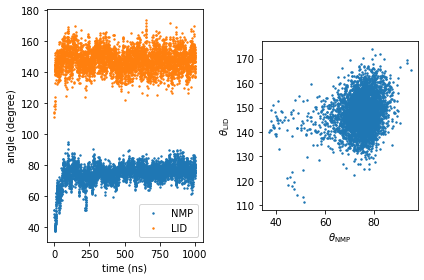

In [59]:
# Bonus exercise -- solution
from MDAnalysisData.datasets import fetch_adk_equilibrium
adk_eq = fetch_adk_equilibrium()

eq_u = mda.Universe(adk_eq.topology, adk_eq.trajectory)

eq_times = np.empty(eq_u.trajectory.n_frames)
eq_LID = np.empty(eq_u.trajectory.n_frames)
eq_NMP = np.empty(eq_u.trajectory.n_frames)

# iterate through the trajectory and gather data
for i, ts in enumerate(eq_u.trajectory):
    eq_times[i] = ts.time / 1000
    eq_LID[i] = theta_LID(eq_u)
    eq_NMP[i] = theta_NMP(eq_u)

# plot
ax1 = plt.subplot(121)
ax1.scatter(eq_times, eq_NMP, label="NMP", s=2)
ax1.scatter(eq_times, eq_LID, label="LID", s=2)
ax1.set_xlabel("time (ns)")
ax1.set_ylabel("angle (degree)")
ax1.legend(loc="best")
ax2 = plt.subplot(122)
ax2.scatter(eq_NMP, eq_LID, s=2)
ax2.set_xlabel(r"$\theta_\mathrm{NMP}$")
ax2.set_ylabel(r"$\theta_\mathrm{LID}$")
ax2.set_aspect(1)
plt.tight_layout()

In [ ]:
# Bonus exercise

**Bonus exercise 2** - Could you use these metrics (or others) to create a pseudo trajectory of the closed state for the ensemble of simulations?

In [67]:
# Bonus exercise 2
# Let's define the closed state as theta LID < 110, and theta NMP < 50 (a bit abitrary, could be refined)

indices = []

# Using the previously defined `LID` and `NMP` arrays
for i, (lid_angle, nmp_angle) in enumerate(zip(LID, NMP)):
    if lid_angle < 110 and nmp_angle < 50:
        indices.append(i)
        
# now write using the indices
with mda.Writer('closed.dcd', n_atoms=adk_u.trajectory.n_atoms) as W:
    for ts in adk_u.trajectory[indices]:
        W.write(adk_u)
        
# now let's load the new trajectory and visualise it
closed_adk_u = mda.Universe(adk.topology, 'closed.dcd')
nv.show_mdanalysis(closed_adk_u)

NGLWidget(max_frame=195)

In [ ]:
# Bonus exercise 2